## 7.1 Decision Making: Which is the best dataset?

Structure: A decision tree is a simple, interpretable structure that splits data based on certain conditions, forming a tree-like model of decisions. Each internal node represents a "test" on an attribute (e.g., whether the feature is greater than a threshold), each branch represents the outcome of the test, and each leaf node represents a class label.

How it works: The decision tree uses measures like Gini impurity or information gain to decide the best way to split the data at each node. The goal is to create branches such that the dataset is divided into subsets that are as homogeneous as possible.

Advantages:

Easy to understand and interpret, even for non-experts.
Requires less data preprocessing (e.g., no need for normalization).
Can handle both numerical and categorical data.
Disadvantages:

Prone to overfitting, especially if the tree becomes very deep.
Sensitive to small variations in the data, leading to high variance.
Less accurate on unseen data compared to more sophisticated models.

Suitable for simpler tasks, smaller datasets, or when model interpretability is essential.

Setup

In [43]:
import numpy as np
import pandas as pd
import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import export_text
from sklearn.tree import plot_tree

import warnings
from sklearn.exceptions import ConvergenceWarning

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

### Selection of the best dataset

In [44]:
X_train_CON_sel = pd.read_csv("../data/processed/X_train_CON_sel.csv")
X_train_SIN_sel = pd.read_csv("../data/processed/X_train_SIN_sel.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")

X_test_CON_sel = pd.read_csv("../data/processed/X_test_CON_sel.csv")
X_test_SIN_sel = pd.read_csv("../data/processed/X_test_SIN_sel.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")


In [45]:
# Alias para seguir la estructura del notebook de tu compa
X_train_with_outliers_sel = X_train_CON_sel.copy()
X_train_without_outliers_sel = X_train_SIN_sel.copy()

X_test_with_outliers_sel = X_test_CON_sel.copy()
X_test_without_outliers_sel = X_test_SIN_sel.copy()

# IMPORTANT: y debe ser 1D para sklearn
y_train = y_train.squeeze()
y_test = y_test.squeeze()




In [46]:
# train_dicts (dict)
# =====================================================================================
train_dicts = {
  "X_train_with_outliers_sel": X_train_with_outliers_sel,
  "X_train_without_outliers_sel": X_train_without_outliers_sel
}

# test_dicts (dict)
# =====================================================================================
test_dicts = {
  "X_test_with_outliers_sel": X_test_with_outliers_sel,
  "X_test_without_outliers_sel": X_test_without_outliers_sel
}

# -.-.--.-.-.-.-.-.-.-.--.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.--.-.-.-.-.-.-

# train_dfs (list)
# =====================================================================================
train_dfs = [
  X_train_with_outliers_sel,
  X_train_without_outliers_sel
]

# test_dfs (list)
# =====================================================================================
test_dfs = [
  X_test_with_outliers_sel,
  X_test_without_outliers_sel
]

# -.-.--.-.-.-.-.-.-.-.--.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.--.-.-.-.-.-.-

# Print .shape
# =====================================================================================
print("|X_train|")
print("=================================================================")
print(f"X_train_with_outliers_sel shape: {X_train_with_outliers_sel.shape} ")
print(f"X_train_without_outliers_sel shape: {X_train_without_outliers_sel.shape}\n ")

print("|X_test|")
print("=================================================================")
print(f"X_test_with_outliers_sel shape: {X_test_with_outliers_sel.shape} ")
print(f"X_test_without_outliers_sel shape: {X_test_without_outliers_sel.shape}\n ")

print("|Y_train|")
print("=================================================================")
print(f"y_train shape: {y_train.shape}\n ")

print("|Y_test|")
print("=================================================================")
print(f"y_test shape: {y_test.shape} ")

|X_train|
X_train_with_outliers_sel shape: (614, 6) 
X_train_without_outliers_sel shape: (614, 6)
 
|X_test|
X_test_with_outliers_sel shape: (154, 6) 
X_test_without_outliers_sel shape: (154, 6)
 
|Y_train|
y_train shape: (614,)
 
|Y_test|
y_test shape: (154,) 


In [47]:
results = []

for df_index in range(len(train_dfs)):
  model = DecisionTreeClassifier(random_state = 42) # Model initialization and training

  train_df = train_dfs[df_index]
  model.fit(train_df, y_train)

  y_test_pred = model.predict(test_dfs[df_index]) # Model prediction

  results.append(
    {
        "index": df_index,
        "train_df": list(train_dicts.keys())[df_index],
        "Accuracy_score": accuracy_score(y_test, y_test_pred)
  })

resultados = sorted(results, key = lambda x: x["Accuracy_score"], reverse = True)

In [48]:
[{'index': 0,
  'train_df': 'X_train_with_outliers_sel',
  'Accuracy_score': 0.7467532467532467},
 {'index': 1,
  'train_df': 'X_train_without_outliers_sel',
  'Accuracy_score': 0.7402597402597403}]
print (f"The best train dataframe is |{resultados[0]['train_df']}|.\n\
=======================================================      \n\
| Accuracy score: {resultados[0]['Accuracy_score']}   |\n\
========================================")

The best train dataframe is |X_train_with_outliers_sel|.
| Accuracy score: 0.6753246753246753   |


## Model hyperparameters optimization

### Grid Search

In [49]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(train_dfs[0], y_train)
y_pred = model.predict(test_dfs[0])

base_accuracy = accuracy_score(y_test, y_pred)
print(f" The base_accuracy is: {base_accuracy}")

 The base_accuracy is: 0.6753246753246753


In [50]:
# We define the parameters that we want to adjust by hand
hyperparams = {
    "criterion": ["entropy", "gini"], # 'gini' es generalmente más rápido, mientras que, 'entropy' puede ser preferible si se busca una medida basada en la información
    "max_depth": [8, 10, 12, 14, 16], # Significa que el árbol no tendrá más de 12 niveles. Valor mayor = complejo / Valor menor = simplificado.
    "random_state": [42], # To obtain a deterministic behaviour during fitting, random_state has to be fixed to an integer.
    "splitter": ["best", "random"], # The strategy used to choose the split at each node
        # 'best' (elige la mejor división) tiende a dar un rendimiento más alto 
        # & 
        # 'random' (elige una división aleatoria) puede ser más rápido y útil para modelos como Random Forest.
    "min_weight_fraction_leaf": [0.085, 0.09, 0.095, 0.1, 0.15, 0.2]
}

# We initialize the grid
grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 8)
grid

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'criterion': ['entropy', 'gini'], 'max_depth': [8, 10, ...], 'min_weight_fraction_leaf': [0.085, 0.09, ...], 'random_state': [42], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",8
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for ea

In [51]:
grid.fit(train_dfs[0], y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 8, 'min_weight_fraction_leaf': 0.095, 'random_state': 42, 'splitter': 'best'}


In [52]:
model_grid = DecisionTreeClassifier(criterion = 'gini',
                                    max_depth = 8,
                                    min_weight_fraction_leaf = 0.09,
                                    random_state = 42,
                                    splitter = 'best')
model_grid.fit(train_dfs[1], y_train)

y_pred = model_grid.predict(test_dfs[1])

grid_accuracy = accuracy_score(y_test, y_pred)
print(f" The grid_accuracy is: {grid_accuracy}")

 The grid_accuracy is: 0.7987012987012987


In [53]:
print(f"We have an increment of {round(((grid_accuracy - base_accuracy)/base_accuracy)*100, 2)}%")

We have an increment of 18.27%


In [54]:
decision_tree = export_text(model_grid, feature_names = train_dfs[0].columns)
print(decision_tree)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 31.25
|   |   |   |--- Glucose <= 101.50
|   |   |   |   |--- class: 0
|   |   |   |--- Glucose >  101.50
|   |   |   |   |--- class: 0
|   |   |--- BMI >  31.25
|   |   |   |--- class: 0
|   |--- Age >  28.50
|   |   |--- Glucose <= 100.50
|   |   |   |--- class: 0
|   |   |--- Glucose >  100.50
|   |   |   |--- class: 0
|--- Glucose >  127.50
|   |--- BMI <= 29.95
|   |   |--- class: 0
|   |--- BMI >  29.95
|   |   |--- Glucose <= 157.50
|   |   |   |--- class: 1
|   |   |--- Glucose >  157.50
|   |   |   |--- class: 1



Decision Tree Visual

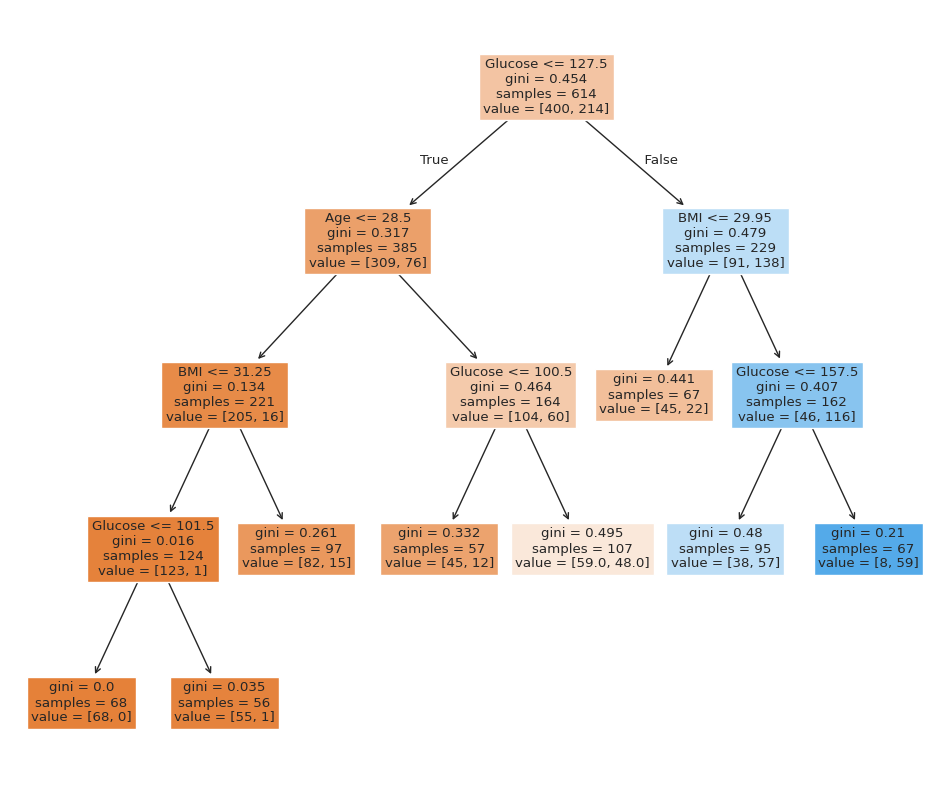

In [55]:
plt.figure(figsize=(12,10))

plot_tree(model_grid, 
            feature_names = train_dfs[0].columns, 
                filled = True
)

plt.show()

Conclusions

Glucose shows the strongest relationship with Outcome. Higher glucose values are clearly associated with a higher probability of diabetes, making it one of the most informative predictors.

BMI and Age tend to show a moderate positive association with Outcome. The probability of diabetes increases as BMI and age rise, although the separation between classes is less sharp than with glucose.

Pregnancies and DiabetesPedigreeFunction show weaker but meaningful trends. They contribute signal, but with substantial overlap between classes, so they are better as complementary predictors.

BloodPressure, SkinThickness, and Insulin appear noisier. Their relationship with Outcome is less stable, partly influenced by outliers and the presence of many zero values (likely missing/placeholder measurements).

Correlation with Outcome is not the whole story. Even variables with low linear correlation can improve classification when combined in a model, especially with non-linear learners (like Decision Trees).